In [1]:
#Importing the dataframe from Excel
import pandas as pd

df=pd.read_excel('C:/Users/vikra/.spyder-py3/CMC Database.xlsx', sheet_name = 'Sheet4', header=0)

print(df)

     Serial No.  Surfactant No.        Charge           Surfactant Name  \
0             1             1.0       Anionic  Sodium Dodecyl 1 Sulfate   
1             2             NaN       Anionic  Sodium Dodecyl 1 Sulfate   
2             3             2.0       Anionic    Sodium Octyl 1 Sulfate   
3             4             NaN       Anionic    Sodium Octyl 1 Sulfate   
4             5             3.0       Anionic    Sodium Decyl 1 Sulfate   
..          ...             ...           ...                       ...   
262         263           256.0  Zwitterionic  C12H25N+(CH3)2(CH2)5COO−   
263         264           257.0  Zwitterionic  C12H25N+(CH3)2(CH2)7COO−   
264         265           258.0  Zwitterionic     C8H17CH(COO-)N+(CH3)3   
265         266           259.0  Zwitterionic    C10H21CH(COO-)N+(CH3)3   
266         267           260.0  Zwitterionic    C12H25CH(COO-)N+(CH3)3   

    Formula                   Head Group  \
0       NaN                      Sulfate   
1       NaN

In [2]:
# Identify target column (output). For this example, wine quality is the target property
target = ['-log CMC']
# Identify features (inputs)
features = (list(set(list(df.columns))-set(target)))
# Print features
features

['Charge',
 'Surfactant No.',
 'Surfactant Name',
 '2^-log(CMC)',
 'Head Group',
 'CMC (M)',
 'Formula',
 'Temp (oC)',
 'SMILES Representation',
 'Serial No.']

In [3]:
headers = df.columns.tolist()
headers

['Serial No.',
 'Surfactant No.',
 'Charge',
 'Surfactant Name',
 'Formula',
 'Head Group',
 'SMILES Representation',
 'Temp (oC)',
 'CMC (M)',
 '-log CMC',
 '2^-log(CMC)']

In [4]:
#Creating dataset with only required data

df2 = df.drop(df.columns[[0,1,2,3,4,5,8,10]], axis= 1)

#df2 = df2.loc[0:8, :]
#df2 = df2.reset_index()
#df2 = df2.drop(['index'], axis= 1)

df2

,SMILES Representation,Temp (oC),-log CMC
0,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,2.072117
1,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],25,2.080922
2,CCCCCCCCOS(=O)(=O)[O-].[Na+],20,0.873869
3,CCCCCCCCOS(=O)(=O)[O-].[Na+],25,0.885056
4,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,1.474955
...,...,...,...
262,CCCCCCCCCCCC[N+](C)(C)CCCCCC(=O)[O-],25,2.585027
263,CCCCCCCCCCCC[N+](C)(C)CCCCCCCC(=O)[O-],25,2.823909
264,CCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.013228
265,CCCCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.886057


In [5]:
#Checks to see if there is any null values within each of the columns of the database.
df2.isnull().sum()

SMILES Representation    0
Temp (oC)                0
-log CMC                 0
dtype: int64

In [6]:
import numpy as np
import rdkit as rd
from rdkit import Chem, DataStructs, rdBase
#draw the molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AtomPairs
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect

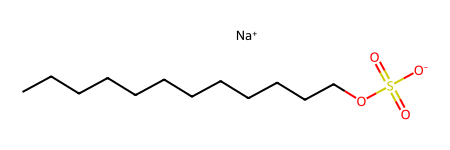

In [7]:
smile = df2.iloc[0,0]
mol = Chem.MolFromSmiles(smile)
mol

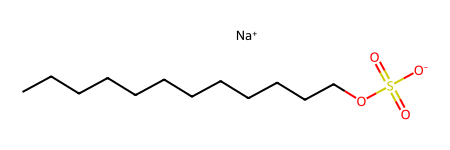

In [8]:
smile = df2.iloc[1,0]
mol = Chem.MolFromSmiles(smile)
mol

In [9]:
#Create a function that will convert the smiles into a morgan fingerprint
def MoleculeGen(rad: int, dataframe: pd.DataFrame) -> pd.DataFrame:
    #initilise empty lists for holding the mol drawings and morgan fingerprints
    mol_list = []
    fin_list = []
    i = 0
    
    for smile in dataframe['SMILES Representation']:
        i += 1
        try:
            #Generate the molecular drawing of the smile
            mol = Chem.MolFromSmiles(smile)
            mol_list.append(mol)
            #Generate the morgan fingerprint of the smile in question
            mf_bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius= rad, nBits= 2**8)
            #initialise a temporary array that will have the bit vector mapped onto to convert from bit vector to numpy array\
            #(this is because we can only use np arrays and not bit vectors within python)
            temp = np.zeros((0,), dtype= np.int8)
            DataStructs.ConvertToNumpyArray(mf_bitvect, temp)
            fin_list.append(temp)
           
        except:
            print(i, smile)
    #convert the np array to a dataframe that we can then add to the main dataframe in question
    fin_list = pd.DataFrame(fin_list)
    #Add the fingerprint list to the main dataframe along the columns (axis = 1)
    dataframe = pd.concat([dataframe, fin_list], axis= 1)
    return dataframe

In [10]:
#Call the function to generate the fingerprints
df3 = MoleculeGen(7, df2)

#drop the smile columns since this will  not be passed to the machine learning model
df3 = df3.drop(['SMILES Representation'], axis = 1)
#denote the target heading
target = ['-log CMC']
#define all other headings as the input features for the model
features = (list(set(list(df3.columns))-set(target)))
#get the values of the input features and output features
x_data = df3[features].values
y_data = df3[target].values
x_data.shape

df3

[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerator
[20:02:03] DEPRECATION WARNING: please use MorganGenerat

,Temp (oC),-log CMC,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,20,2.072117,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,25,2.080922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,20,0.873869,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,25,0.885056,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20,1.474955,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,25,2.585027,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
263,25,2.823909,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
264,27,1.013228,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
265,27,1.886057,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [11]:
# Import scikit learn classifier and regressor.
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# Tool for splitting sets. Needed to split training and test data
from sklearn.model_selection import train_test_split

# Module to normalized data
from sklearn import preprocessing

# Tool for calculation of the mean square error (mse)
from sklearn.metrics import mean_squared_error

# Tool for calculating R2 score
from sklearn.metrics import r2_score


# Split data for training and testing. In this example, the splits is 80:20
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2,random_state=5,shuffle=True)

print(x_train.shape)
print(x_test.shape)

(213, 257)
(54, 257)


In [12]:
#Creating 2 layer ML models


#Enter desired number of nodes:
max_number_of_nodes = 10

i = max_number_of_nodes

R2_MSE_values = np.zeros((i**2,3))

#Array to store info on nodes, R^2 and MSE:
info_array = np.zeros((i**2,4))
l = 0


for j in range(1,i+1):
    for k in range(1, i+1):
        
        
        # Create an Artificial Neural Network architecture
        clf = MLPRegressor(hidden_layer_sizes=(k,j),solver='lbfgs',alpha=1e-5,random_state=5,max_iter=2000)
        
        #Which iteration is being run
        itr = ((j-1)*i)+k
        
        # Fit data to the ANN
        clf.fit(x_train,y_train.ravel())
        r2 = clf.score(x_train,y_train.ravel())
        R2_MSE_values[itr-1,0] = r2
        
        # Find Mean Square Error of Test Dataset
        predict_train_set = clf.predict(x_train)
        predict_test_set = clf.predict(x_test)
        mse=mean_squared_error(y_test, predict_test_set, squared=False)
        R2_MSE_values[itr-1,1] = mse
        predict_overall_set = clf.predict(x_data)
        R2_MSE_values[itr-1,2] = mean_squared_error(y_data, predict_overall_set, squared=False)
        print(itr, j, k,'R^2:', r2, ', MSE:', round(mse, 2))



            

1 1 1 R^2: -4.7264903102473e-10 , MSE: 1.16
2 1 2 R^2: 0.9892475230123764 , MSE: 0.55
3 1 3 R^2: 0.0 , MSE: 1.16
4 1 4 R^2: 2.220446049250313e-16 , MSE: 1.16
5 1 5 R^2: 0.0 , MSE: 1.16
6 1 6 R^2: -2.220446049250313e-16 , MSE: 1.16
7 1 7 R^2: 0.9714362875767832 , MSE: 0.45
8 1 8 R^2: 0.9751314107949894 , MSE: 0.42
9 1 9 R^2: 0.0 , MSE: 1.16
10 1 10 R^2: 0.0 , MSE: 1.16


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


11 2 1 R^2: 0.991081725579849 , MSE: 0.61
12 2 2 R^2: -1.6895373988745632e-12 , MSE: 1.16
13 2 3 R^2: -1.3025136524902337e-12 , MSE: 1.16
14 2 4 R^2: 0.9793337097670438 , MSE: 0.37
15 2 5 R^2: 0.984667921543011 , MSE: 0.48
16 2 6 R^2: 0.9912876995822891 , MSE: 0.62
17 2 7 R^2: 0.9919638408683872 , MSE: 0.39
18 2 8 R^2: 0.9903896310176677 , MSE: 0.52
19 2 9 R^2: 2.220446049250313e-16 , MSE: 1.16
20 2 10 R^2: 2.220446049250313e-16 , MSE: 1.16
21 3 1 R^2: -5.583089546234987e-12 , MSE: 1.16
22 3 2 R^2: 2.220446049250313e-16 , MSE: 1.16
23 3 3 R^2: -6.752043368862815e-11 , MSE: 1.16
24 3 4 R^2: 0.991445574874326 , MSE: 0.56
25 3 5 R^2: -2.7195392604539848e-09 , MSE: 1.16
26 3 6 R^2: 0.9918285989315034 , MSE: 0.55
27 3 7 R^2: -2.220446049250313e-16 , MSE: 1.16
28 3 8 R^2: 0.9919856173386858 , MSE: 0.45


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


29 3 9 R^2: 0.9919194322881706 , MSE: 0.53
30 3 10 R^2: 0.9917349629174192 , MSE: 0.42
31 4 1 R^2: 0.9917105106635948 , MSE: 0.63
32 4 2 R^2: -1.241229341530925e-13 , MSE: 1.16
33 4 3 R^2: -1.1936927002409448e-09 , MSE: 1.16
34 4 4 R^2: 0.9918290729516562 , MSE: 0.54
35 4 5 R^2: 0.9918204525668828 , MSE: 0.61
36 4 6 R^2: 0.9594067425455786 , MSE: 0.42
37 4 7 R^2: 0.9921295539982539 , MSE: 0.59
38 4 8 R^2: 0.9918157498919115 , MSE: 0.46
39 4 9 R^2: 0.9919508305955471 , MSE: 0.47
40 4 10 R^2: 0.9918495603281793 , MSE: 0.56
41 5 1 R^2: 0.9899590685959123 , MSE: 0.56
42 5 2 R^2: -4.8403296926124995e-09 , MSE: 1.16
43 5 3 R^2: -2.1544988015875788e-12 , MSE: 1.16
44 5 4 R^2: 0.9917980006468335 , MSE: 0.52
45 5 5 R^2: 0.9916523503953567 , MSE: 0.6
46 5 6 R^2: 0.9909310713099867 , MSE: 0.31
47 5 7 R^2: 0.9919344807605386 , MSE: 0.63
48 5 8 R^2: -2.2648549702353193e-14 , MSE: 1.16


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


49 5 9 R^2: 0.9865319585741185 , MSE: 0.49
50 5 10 R^2: 0.9915916353194575 , MSE: 0.38
51 6 1 R^2: 0.9918326972059944 , MSE: 0.61
52 6 2 R^2: 0.9917654599830397 , MSE: 0.61
53 6 3 R^2: -4.554578936222242e-12 , MSE: 1.16
54 6 4 R^2: 0.9912486712828592 , MSE: 0.61
55 6 5 R^2: 0.9918757611315092 , MSE: 0.41
56 6 6 R^2: 0.9917563202156932 , MSE: 0.6
57 6 7 R^2: -1.8429702208777599e-13 , MSE: 1.16
58 6 8 R^2: 0.9917966769623638 , MSE: 0.64


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


59 6 9 R^2: 0.9902737118205202 , MSE: 0.41


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


60 6 10 R^2: 0.9918665354179627 , MSE: 0.48
61 7 1 R^2: -3.086420008457935e-14 , MSE: 1.16
62 7 2 R^2: -4.4512393770901326e-11 , MSE: 1.16
63 7 3 R^2: -4.424089983245949e-10 , MSE: 1.16
64 7 4 R^2: 0.9913342297250537 , MSE: 0.59
65 7 5 R^2: 0.6041713538489806 , MSE: 0.78


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


66 7 6 R^2: 0.9908424916634407 , MSE: 0.34
67 7 7 R^2: 0.9917509104170719 , MSE: 0.61
68 7 8 R^2: 0.9920155950024445 , MSE: 0.49
69 7 9 R^2: 0.9902029593487368 , MSE: 0.55
70 7 10 R^2: 0.9920171058914543 , MSE: 0.34
71 8 1 R^2: -4.765077221691172e-13 , MSE: 1.16
72 8 2 R^2: 0.9917182369377341 , MSE: 0.61
73 8 3 R^2: -8.604006396240038e-12 , MSE: 1.16
74 8 4 R^2: 0.9920497672958478 , MSE: 0.4


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


75 8 5 R^2: 0.9752699903247584 , MSE: 0.43


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


76 8 6 R^2: 0.9919291209287118 , MSE: 0.64


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


77 8 7 R^2: 0.9912154779636038 , MSE: 0.34
78 8 8 R^2: 0.9918726472926644 , MSE: 0.4
79 8 9 R^2: 0.9917954890533723 , MSE: 0.46
80 8 10 R^2: 0.9917563371722651 , MSE: 0.62
81 9 1 R^2: -9.392486788328824e-14 , MSE: 1.16
82 9 2 R^2: 0.9911836786669573 , MSE: 0.6
83 9 3 R^2: -5.150546655841026e-12 , MSE: 1.16
84 9 4 R^2: 0.9917232153114446 , MSE: 0.63
85 9 5 R^2: 0.9311676923065998 , MSE: 0.46
86 9 6 R^2: 0.991293940590148 , MSE: 0.49
87 9 7 R^2: 0.9909986791408589 , MSE: 0.58
88 9 8 R^2: 0.9917646750560598 , MSE: 0.48


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


89 9 9 R^2: 0.9919789216986068 , MSE: 0.51
90 9 10 R^2: 0.9572041102670773 , MSE: 0.43
91 10 1 R^2: -2.00361949254102e-11 , MSE: 1.16


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


92 10 2 R^2: 0.9915631342854957 , MSE: 0.62
93 10 3 R^2: -3.784417224039771e-11 , MSE: 1.16
94 10 4 R^2: 0.9918259109904923 , MSE: 0.57
95 10 5 R^2: 0.9386561266532392 , MSE: 0.46
96 10 6 R^2: 0.9896002344802199 , MSE: 0.38
97 10 7 R^2: 0.9918421750045003 , MSE: 0.41
98 10 8 R^2: 0.991754597767442 , MSE: 0.56
99 10 9 R^2: 0.9918004802942242 , MSE: 0.62
100 10 10 R^2: 0.9916812868753525 , MSE: 0.41


In [36]:
#Creating array with info for Contour Plots
info_array = np.zeros((i**2,5))

i = 0

j = max_number_of_nodes

while True:
       
    if (i+1)%j == 0:
        info_array[i,0] = int(((i+1)//j))
        info_array[i,1] = j
    else:
        info_array[i,0] = int(((i+1)//j) + 1)
        info_array[i,1] = int((i+1)%j)
    info_array[i,2] = R2_MSE_values[i,0]
    info_array[i,3] = R2_MSE_values[i,1]
    info_array[i,4] = R2_MSE_values[i,2]
    
    i += 1

info_array

IndexError: index 100 is out of bounds for axis 0 with size 100

Text(0, 0.5, 'Nodes in second layer')

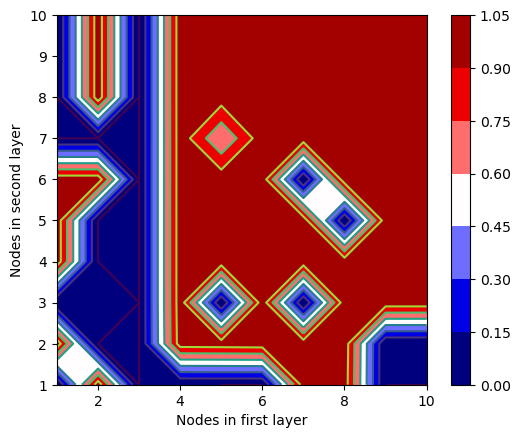

In [37]:
#R^2 Contour Map For 2 layer models

import matplotlib.pyplot as plt

x = [1,2,3,4,5,6,7,8,9,10]
y = [1,2,3,4,5,6,7,8,9,10]
z1 = info_array[:,2]

Z = np.zeros((10,10))

for i in range(0,10):
    for j in range(0,10):
        if z1[(i*10) + j]>0:
            Z[i,j] = z1[(i*10) + j]
        else:
            Z[i,j] = 0



        
fig,ax = plt.subplots()
ax.contour(x,y,Z)

ax.set_aspect('equal')
cf = ax.contourf(x,y,Z, cmap='seismic')
fig.colorbar(cf, ax=ax)

ax.set_xlabel('Nodes in first layer')
ax.set_ylabel('Nodes in second layer')



Text(0, 0.5, 'Nodes in second layer')

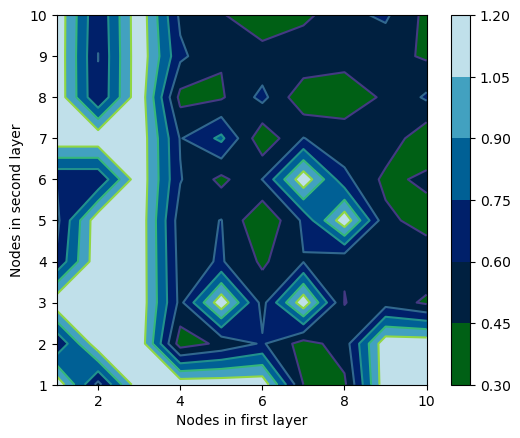

In [38]:
#Test MSE Contour Map For 2 layer models

x = [1,2,3,4,5,6,7,8,9,10]
y = [1,2,3,4,5,6,7,8,9,10]
z2 = info_array[:,3]

Z = np.zeros((10,10))

for i in range(0,10):
    for j in range(0,10):
        if z2[(i*10) + j]>0:
            Z[i,j] = z2[(i*10) + j]
        else:
            Z[i,j] = 0


            
fig,ax = plt.subplots()
ax.contour(x,y,Z)

ax.set_aspect('equal')
cf = ax.contourf(x,y,Z, cmap='ocean')
fig.colorbar(cf, ax=ax)

ax.set_xlabel('Nodes in first layer')
ax.set_ylabel('Nodes in second layer')

        


Text(0, 0.5, 'Nodes in second layer')

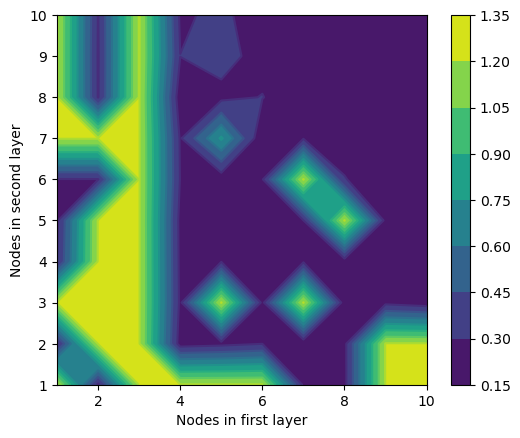

In [39]:
#Overall MSE Contour Map For 2 layer models

z3 = info_array[:,4]

Z = np.zeros((10,10))

for i in range(0,10):
    for j in range(0,10):
        if z3[(i*10) + j]>0:
            Z[i,j] = z3[(i*10) + j]
        else:
            Z[i,j] = 0

fig,ax = plt.subplots()
ax.contour(x,y,Z)

ax.set_aspect('equal')
cf = ax.contourf(x,y,Z, cmap='viridis')
fig.colorbar(cf, ax=ax)

ax.set_xlabel('Nodes in first layer')
ax.set_ylabel('Nodes in second layer')



In [41]:
#Creating single layer ML models with varying number of nodes

single_layer_max = 10

data_array = np.zeros((single_layer_max, 5))

for k in range(1, single_layer_max+1):
    
    # Create an Artificial Neural Network architecture
    clf = MLPRegressor(hidden_layer_sizes=(k,),solver='lbfgs',alpha=1e-5,random_state=5,max_iter=2000)
    
    # Fit data to the ANN
    clf.fit(x_train,y_train.ravel())
    r2 = clf.score(x_train,y_train.ravel())
    
    # Find Mean Square Error of Test Dataset
    predict_train_set = clf.predict(x_train)
    predict_test_set = clf.predict(x_test)
    predict_data_set = clf.predict(x_data)
    train_mse = mean_squared_error(y_train, predict_train_set, squared=False) 
    test_mse = mean_squared_error(y_test, predict_test_set, squared=False)
    overall_mse = mean_squared_error(y_data, predict_data_set, squared=False)
    
    data_array[k-1,0] = k
    data_array[k-1,1] = r2
    data_array[k-1,2] = train_mse
    data_array[k-1,3] = test_mse
    data_array[k-1,4] = overall_mse
         
    print(k,'R^2:', r2, 'Training MSE:', round(train_mse, 2), ', Test MSE:', round(test_mse, 2), ', Overall MSE:', round(overall_mse, 2))
    
data_array

1 R^2: 2.220446049250313e-16 Training MSE: 1.22 , Test MSE: 1.16 , Overall MSE: 1.21
2 R^2: 0.9918001004442244 Training MSE: 0.11 , Test MSE: 0.6 , Overall MSE: 0.29
3 R^2: 0.0 Training MSE: 1.22 , Test MSE: 1.16 , Overall MSE: 1.21
4 R^2: 0.9919708020030139 Training MSE: 0.11 , Test MSE: 0.48 , Overall MSE: 0.24


C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


5 R^2: 0.9915949262290814 Training MSE: 0.11 , Test MSE: 0.62 , Overall MSE: 0.3
6 R^2: 0.9918804086275403 Training MSE: 0.11 , Test MSE: 0.5 , Overall MSE: 0.25
7 R^2: 0.9919834206577707 Training MSE: 0.11 , Test MSE: 0.39 , Overall MSE: 0.2
8 R^2: 0.9918393825411018 Training MSE: 0.11 , Test MSE: 0.48 , Overall MSE: 0.24
9 R^2: 0.991826156570605 Training MSE: 0.11 , Test MSE: 0.66 , Overall MSE: 0.31
10 R^2: 0.9918252315765923 Training MSE: 0.11 , Test MSE: 0.59 , Overall MSE: 0.28


array([[1.00000000e+00, 2.22044605e-16, 1.22204323e+00, 1.16050167e+00,
        1.20984919e+00],
       [2.00000000e+00, 9.91800100e-01, 1.10660043e-01, 6.00841269e-01,
        2.87719139e-01],
       [3.00000000e+00, 0.00000000e+00, 1.22204323e+00, 1.16050167e+00,
        1.20984919e+00],
       [4.00000000e+00, 9.91970802e-01, 1.09502152e-01, 4.80628366e-01,
        2.37245582e-01],
       [5.00000000e+00, 9.91594926e-01, 1.12035933e-01, 6.24100866e-01,
        2.97974993e-01],
       [6.00000000e+00, 9.91880409e-01, 1.10116819e-01, 5.00283301e-01,
        2.45545175e-01],
       [7.00000000e+00, 9.91983421e-01, 1.09416072e-01, 3.90658818e-01,
        2.01038340e-01],
       [8.00000000e+00, 9.91839383e-01, 1.10394664e-01, 4.80537231e-01,
        2.37538034e-01],
       [9.00000000e+00, 9.91826157e-01, 1.10484086e-01, 6.56304539e-01,
        3.11212196e-01],
       [1.00000000e+01, 9.91825232e-01, 1.10490337e-01, 5.88663139e-01,
        2.82528976e-01]])

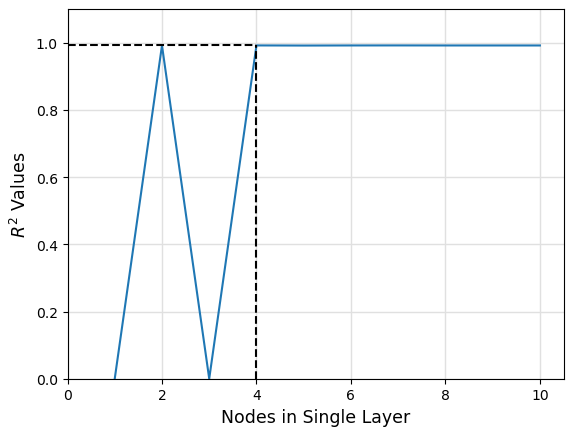

<Figure size 5940x5400 with 0 Axes>

In [42]:
#R^2 plot for Single layer ML model variants

from matplotlib.pyplot import figure

#plt.figure(figsize=(12,8))
ax1=plt.subplot(1, 1, 1)

ax1.plot(data_array[:,0], data_array[:,1], )


poi = 4 # Point of interest
ax1.plot([poi, poi],[0,data_array[poi-1,1]], '--k')
ax1.plot([0,poi],[data_array[poi-1,1],data_array[poi-1,1]], '--k')

ax1.set_xlim([0,10.5])
ax1.set_ylim([0,1.1])

ax1.set_xlabel('Nodes in Single Layer',size=12.5)
ax1.set_ylabel('$R^2$ Values',size=12.5)

figure(figsize=(3.3, 3), dpi=1800)
  
## Grid
ax1.grid(True, color='#e0e0e0', which='both', linewidth=1)

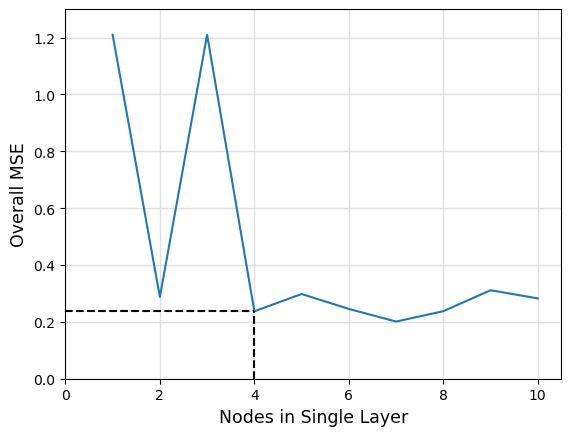

<Figure size 5940x5400 with 0 Axes>

In [47]:
#Overall MSE plot for Single layer ML model variants

ax1=plt.subplot(1, 1, 1)

ax1.plot(data_array[:,0], data_array[:,4], )


poi = 4 # Point of interest
ax1.plot([poi, poi],[0,data_array[poi-1,4]], '--k')
ax1.plot([0,poi],[data_array[poi-1,4],data_array[poi-1,4]], '--k')

ax1.set_xlim([0,10.5])
ax1.set_ylim([0,1.3])

ax1.set_xlabel('Nodes in Single Layer',size=12.5)
ax1.set_ylabel('Overall MSE',size=12.5)

figure(figsize=(3.3, 3), dpi=1800)
  
## Grid
ax1.grid(True, color='#e0e0e0', which='both', linewidth=1)

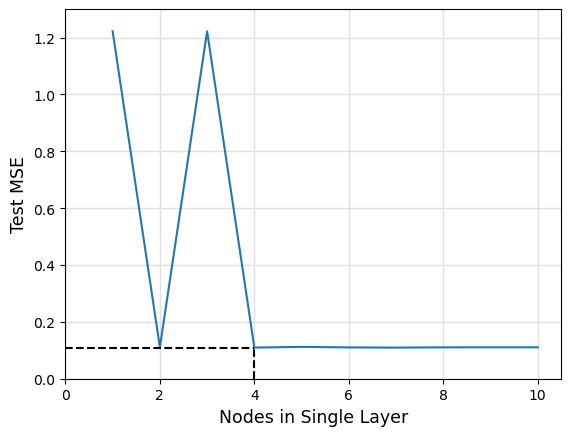

<Figure size 5940x5400 with 0 Axes>

In [49]:
#Training data plot for Single layer ML model variants

ax1=plt.subplot(1, 1, 1)

ax1.plot(data_array[:,0], data_array[:,2], )


poi = 4 # Point of interest
ax1.plot([poi, poi],[0,data_array[poi-1,2]], '--k')
ax1.plot([0,poi],[data_array[poi-1,2],data_array[poi-1,2]], '--k')

ax1.set_xlim([0,10.5])
ax1.set_ylim([0,1.3])

ax1.set_xlabel('Nodes in Single Layer',size=12.5)
ax1.set_ylabel('Training MSE',size=12.5)

figure(figsize=(3.3, 3), dpi=1800)
  
## Grid
ax1.grid(True, color='#e0e0e0', which='both', linewidth=1)

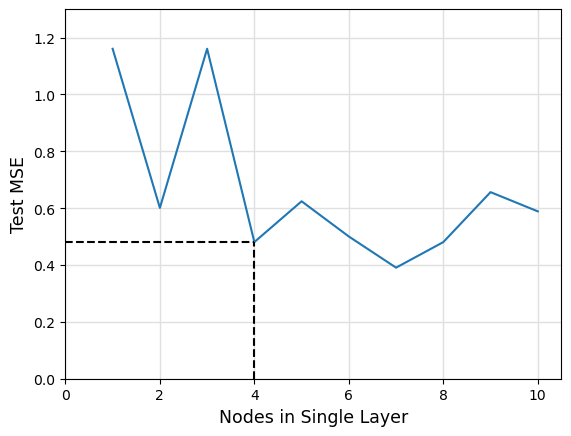

<Figure size 5940x5400 with 0 Axes>

In [45]:
#Test MSE plot for Single layer ML model variants
ax1=plt.subplot(1, 1, 1)

ax1.plot(data_array[:,0], data_array[:,3], )


poi = 4 # Point of interest
ax1.plot([poi, poi],[0,data_array[poi-1,3]], '--k')
ax1.plot([0,poi],[data_array[poi-1,3],data_array[poi-1,3]], '--k')

ax1.set_xlim([0,10.5])
ax1.set_ylim([0,1.3])

ax1.set_xlabel('Nodes in Single Layer',size=12.5)
ax1.set_ylabel('Test MSE',size=12.5)

figure(figsize=(3.3, 3), dpi=1800)
  
## Grid
ax1.grid(True, color='#e0e0e0', which='both', linewidth=1)